### IMPORTS

In [5]:
from Inference import BBVI 

In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np

### EXAMPLE

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [8]:
x_data = torch.distributions.uniform.Uniform(-1.0, 1.0).sample([200,1]).to(device)

In [9]:
A = 1.2
b = -0.5
y_data = A*x_data + b
y_data = y_data + torch.distributions.normal.Normal(0,0.1).sample([200,1]).to(device)

In [10]:
Net = BBVI.VariationalNetwork(input_size=1, output_size=1, layer_width=1, nb_layers=1, device=device)
Net.activation = None

In [11]:
Net.sample_parameters(1)
pass

In [12]:
out = Net(x_data)

In [13]:
Net.linear1.prior_weight_mu

Parameter containing:
tensor([[0.]], device='cuda:0')

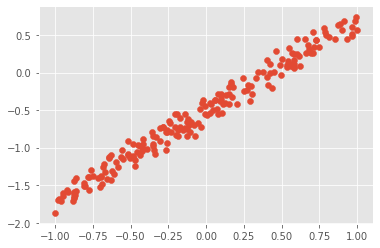

In [14]:
plt.scatter(x_data.detach().cpu(), y_data.detach().cpu()) 

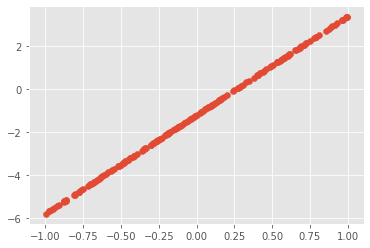

In [15]:
plt.scatter(x_data.detach().cpu(), out[0,:,:].detach().cpu()) 

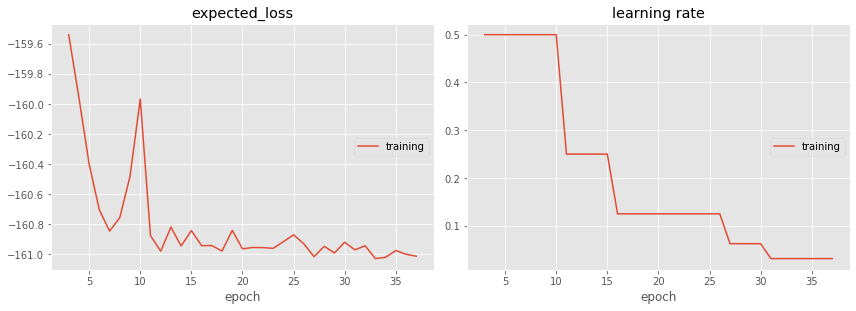

expected_loss:
training   (min: -161.030, max: 2867.543, cur: -161.014)

learning rate:
training   (min:    0.031, max:    0.500, cur:    0.031)


KeyboardInterrupt: 

In [16]:
optimizer = torch.optim.Adam
optimizer_params = {'lr': 0.5}
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau
scheduler_params = {'patience': 2, 'factor': 0.5}

voptimizer = BBVI.VariationalOptimizer(model=Net, sigma_noise=0.1, optimizer=optimizer, optimizer_params=optimizer_params, scheduler=scheduler, scheduler_params=scheduler_params, min_lr=0.00001)
Net = voptimizer.run((x_data,y_data), n_epoch=10000, n_iter=50, n_ELBO_samples=20, plot=True)

In [17]:
x_test = torch.linspace(-2.0, 2.0).unsqueeze(1).to(device)

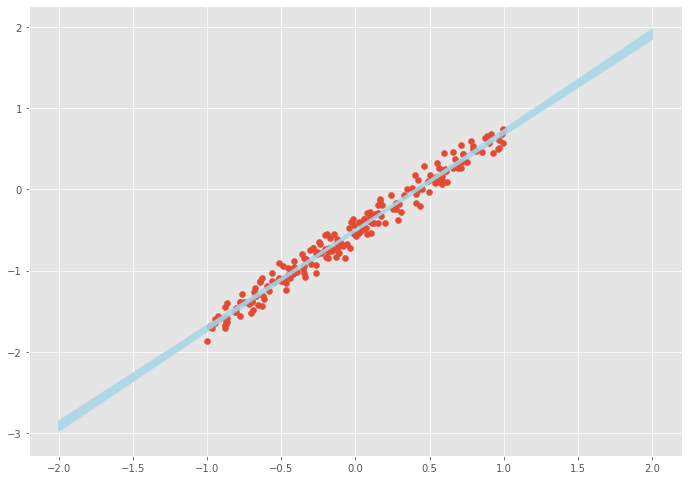

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.scatter(x_data.cpu(), y_data.cpu())
for _ in range(1000):
    Net.sample_parameters()

    y_test = Net.forward(x_test)
    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')

In [19]:
Net.linear1.q_weight_mu

Parameter containing:
tensor([[1.2063]], device='cuda:0', requires_grad=True)

In [20]:
Net.linear1._rho_to_sigma(Net.linear1.q_weight_rho)

tensor([[0.0128]], device='cuda:0', grad_fn=<LogBackward>)

In [21]:
Net.linear1.q_bias_mu

Parameter containing:
tensor([-0.5065], device='cuda:0', requires_grad=True)

In [22]:
Net.linear1._rho_to_sigma(Net.linear1.q_bias_rho)

tensor([0.0071], device='cuda:0', grad_fn=<LogBackward>)

In [28]:
L = lambda y1, y2: np.abs(y1-y2)**2

In [32]:
def h(x, theta):
    y = theta[0]*x + theta[1]
    return y

In [24]:
def risque_empirique(L,y,X,theta):
    loss = 0
    for i in range(0,np.max(y.shape)):
        y_hat = h(X[i], theta)
        loss = loss + L(y[i], y_hat)
    return loss/float(np.max(y.shape))

In [25]:
def regularisation(theta):
    return np.sum(np.abs(theta)**2)

In [26]:
def objective(L,y,X,r,theta):
    return risque_empirique(L,y,X,theta) + r*regularisation(theta)

In [38]:
from mpl_toolkits.mplot3d import Axes3D 

In [30]:
X = x_data.detach().cpu().numpy()
y = y_data.detach().cpu().numpy()

In [47]:
M = 25
linspace_A = np.linspace(-10, 10, M)
linspace_b = np.linspace(-10, 10, M)
R = np.zeros((M, M))
r = 1.0
for i in range(0,M):
    for j in range(0,M):
        theta = np.array([linspace_A[i], linspace_b[j]])
        R[i,j] = np.log(objective(L,y,X,r,theta)) 

<IPython.core.display.Javascript object>


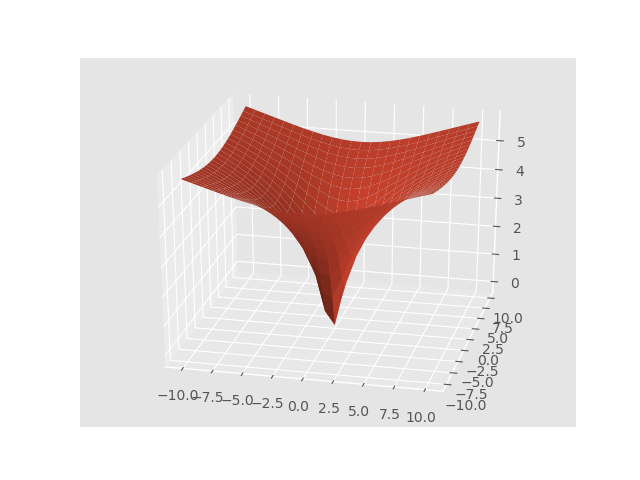

In [48]:
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection='3d')
mesh_A, mesh_b = np.meshgrid(linspace_A, linspace_b)
ax.plot_surface(mesh_A, mesh_b, R)
plt.show()